In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# solve the equations
the constants we use:
k=10,alpha=1e-4,beta=8*1e-4,deltaT=20
get_q1,get_q2 and get_q3 are functions that calculate 3 different branches of q , gets is the function that calculate delta S using given q

In [6]:
def get_q1(H,k=10,alpha=1e-4,beta=8*1e-4,gamma=10,dt=0.05,T1bar=290,T2bar=270):
    return ((k*alpha*(T1bar-T2bar)/2)+np.sqrt((k*alpha*(T1bar-T2bar)/2)**2-H*k*beta))
def get_q2(H,k=10,alpha=1e-4,beta=8*1e-4,gamma=10,dt=0.05,T1bar=290,T2bar=270):
    return ((k*alpha*(T1bar-T2bar)/2)-np.sqrt((k*alpha*(T1bar-T2bar)/2)**2-H*k*beta))
def get_q3(H,k=10,alpha=1e-4,beta=8*1e-4,gamma=10,dt=0.05,T1bar=290,T2bar=270):
    return ((k*alpha*(T1bar-T2bar)/2)-np.sqrt((k*alpha*(T1bar-T2bar)/2)**2+H*k*beta))
def gets(q,dT=20,k=10,alpha=1e-4,beta=8*1e-4,gamma=10,dt=0.05):
    return (k*alpha*(dT)-q)/(k*beta)


/Users/wandi/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from IPython.kernel.zmq import kernelapp as app
/Users/wandi/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


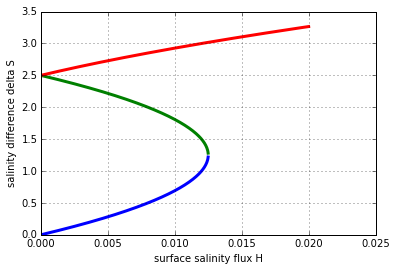

In [7]:
H=np.linspace(0,0.02,1000)
q1=get_q1(H)
q2=get_q2(H)
q3=get_q3(H)
plt.plot(H,gets(q1),lw=3)
plt.plot(H,gets(q2),lw=3)
plt.plot(H,gets(q3),lw=3)
plt.grid(True)
plt.xlabel('surface salinity flux H')
plt.ylabel('salinity difference delta S')


# the stommel two box model

In [8]:

class stommel_model(object):
    def __init__(self,H=0.01,members=1,n=20,k=10,alpha=1e-4,beta=8*1e-4,\
                 gamma=10,dt=0.05,T1bar=270,T2bar=290,S1=30,S2=30,method='normal'):
        self.T1=(np.random.randn(members,n)/1000.+1)*270
        self.T2=(np.random.randn(members,n)/1000.+1)*290
        self.S1=(np.random.randn(members,n)/1000.+1)*S1
        self.S2=(np.random.randn(members,n)/1000.+1)*S2
        self.k=k
        self.H=H
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.dt=dt
        self.T1bar=T1bar
        self.T2bar=T2bar
        self.members=members
        self.n=n
        self.method=method
    def cal_q(self):
        return self.k*(self.alpha*(self.T2-self.T1)-self.beta*(self.S2-self.S1))
    def forward(self):
        
        dT1dt=-abs(self.q)*(self.T2-self.T1)+self.gamma*(self.T1bar-self.T1) 
        dT2dt=abs(self.q)*(self.T2-self.T1)+self.gamma*(self.T2bar-self.T2)
        if self.method=='simplified':
            dT1dt=0   # the simplified model 
            dT2dt=0
        dS1dt=abs(self.q)*(self.S2-self.S1)-self.H
        dS2dt=-abs(self.q)*(self.S2-self.S1)+self.H
        return dT1dt,dT2dt,dS1dt,dS2dt
    
    def rk4step(self):
        self.q=self.cal_q()
        h = self.dt; hh = 0.5*h; h6 = h/6.
        T1=self.T1
        T2=self.T2
        S1=self.S1
        S2=self.S2
        dT1dt1,dT2dt1,dS1dt1,dS2dt1=self.forward()
        self.T1 = T1 + hh*dT1dt1
        self.T2 = T2 + hh*dT2dt1
        self.S1 = S1 + hh*dS1dt1
        self.S2 = S2 + hh*dS2dt1
        dT1dt2,dT2dt2,dS1dt2,dS2dt2=self.forward()
        self.T1 = T1 + hh*dT1dt2
        self.T2 = T2 + hh*dT2dt2
        self.S1 = S1 + hh*dS1dt2
        self.S2 = S2 + hh*dS2dt2
        dT1dt,dT2dt,dS1dt,dS2dt=self.forward()
        self.T1 = T1 + h*dT1dt
        self.T2 = T2 + h*dT2dt
        self.S1 = S1 + h*dS1dt
        self.S2 = S2 + h*dS2dt
   
        dT1dt2=2.0*(dT1dt2+dT1dt)
        dT2dt2=2.0*(dT2dt2+dT2dt)
        dS1dt2=2.0*(dS1dt2+dS1dt)
        dS2dt2=2.0*(dS2dt2+dS2dt)
        dT1dt,dT2dt,dS1dt,dS2dt=self.forward()
        self.T1 = T1 + h6*(dT1dt1 + dT1dt + dT1dt2)
        self.T2 = T2 + h6*(dT2dt1 + dT2dt + dT2dt2)
        self.S1 = S1 + h6*(dS1dt1 + dS1dt + dS1dt2)
        self.S2 = S2 + h6*(dS2dt1 + dS2dt + dS2dt2)
    
    



run the simplified model and with different initiate delta S, see what will happen

In [9]:
init_deltaS=np.linspace(30,33.5,8)
s1=np.zeros([8,10000])
s2=np.zeros([8,10000])
lastq=np.zeros([8,10000])
for  j in range(8):
    m=stommel_model(H=0.015,S1=30,S2=init_deltaS[j],method='simplified')
    es1=np.array([])
    es2=np.array([])
    q=np.array([])
    h=np.array([])

    for i in range(10000):
        m.rk4step()
        es1=np.append(es1,m.S1.mean())
        es2=np.append(es2,m.S2.mean())
        q=np.append(q,m.q.mean())
    s1[j]=es1
    s2[j]=es2
    lastq[j]=q

this is when H is fixed to be 0.015

stable state when H==0.015: []
deltaS: [ 3.0985054   3.11072706  3.11587156  3.10922944  3.09952289  3.11091739
  3.09429294  3.13150583]


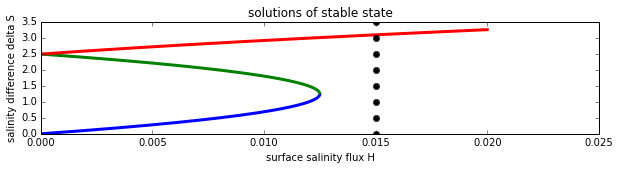

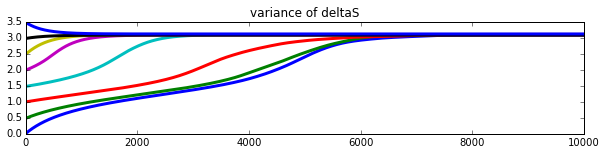

In [10]:
pointx=np.ones(8)*0.015
pointy=np.linspace(0,3.5,8)
plt.figure(figsize=(10,2))
plt.title('solutions of stable state')
plt.plot(H,gets(q1),lw=3)
plt.plot(H,gets(q2),lw=3)
plt.plot(H,gets(q3),lw=3)
plt.plot(pointx,pointy,'ko')
plt.xlabel('surface salinity flux H')
plt.ylabel('salinity difference delta S')
plt.figure(figsize=(10,2))
plt.plot(s2.T-s1.T,lw=3)
plt.title('variance of deltaS')
print ('stable state when H==0.015:',gets(q3[np.where(H==0.015)]))
print ('deltaS:',s2[:,-1]-s1[:,-1])

In [11]:
init_deltaS=np.linspace(30,33.5,8)
s1=np.zeros([8,10000])
s2=np.zeros([8,10000])
lastq=np.zeros([8,10000])
for  j in range(8):
    m=stommel_model(H=0.01,S1=30,S2=init_deltaS[j],method='simplified')
    es1=np.array([])
    es2=np.array([])

    for i in range(10000):
        m.rk4step()
        es1=np.append(es1,m.S1.mean())
        es2=np.append(es2,m.S2.mean())
    s1[j]=es1
    s2[j]=es2
    lastq[j]=q

when H is fixed to be 0.01

stable state when H==0.01: [] [] []
deltaS: [ 0.69490504  0.68880336  0.69931102  0.69497017  2.92196983  2.94240253
  2.94356393  2.91636528]


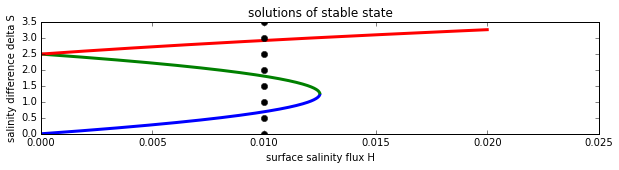

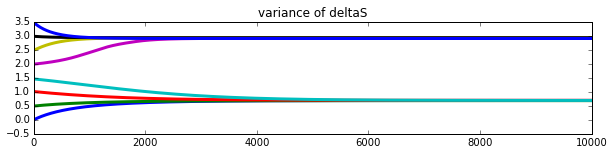

In [12]:
pointx=np.ones(8)*0.010
pointy=np.linspace(0,3.5,8)
plt.figure(figsize=(10,2))
plt.title('solutions of stable state')
plt.plot(H,gets(q1),lw=3)
plt.plot(H,gets(q2),lw=3)
plt.plot(H,gets(q3),lw=3)
plt.plot(pointx,pointy,'ko')
plt.xlabel('surface salinity flux H')
plt.ylabel('salinity difference delta S')
plt.figure(figsize=(10,2))
plt.plot(s2.T-s1.T,lw=3)
plt.title('variance of deltaS')
print ('stable state when H==0.01:',gets(q1[np.where(H==0.01)])\
       ,gets(q2[np.where(H==0.01)]),gets(q3[np.where(H==0.01)]))
print ('deltaS:',s2[:,-1]-s1[:,-1])

change the value of H with time 

In [13]:
H_range=np.linspace(0,0.03,10000)
m=stommel_model(H=0.01,S1=30,S2=30)
n=stommel_model(H=0.01,S1=30,S2=30)
ms1=np.array([])
ms2=np.array([])
ns1=np.array([])
ns2=np.array([])
mq=np.array([])
nq=np.array([])
for i in range(10000):
    m.rk4step()
    n.rk4step()
    ms1=np.append(ms1,m.S1.mean())
    ms2=np.append(ms2,m.S2.mean())
    ns1=np.append(ns1,n.S1.mean())
    ns2=np.append(ns2,n.S2.mean())
    mq=np.append(mq,m.q.mean())
    nq=np.append(nq,n.q.mean())
    m.H=H_range[i]
    n.H=H_range[-i]


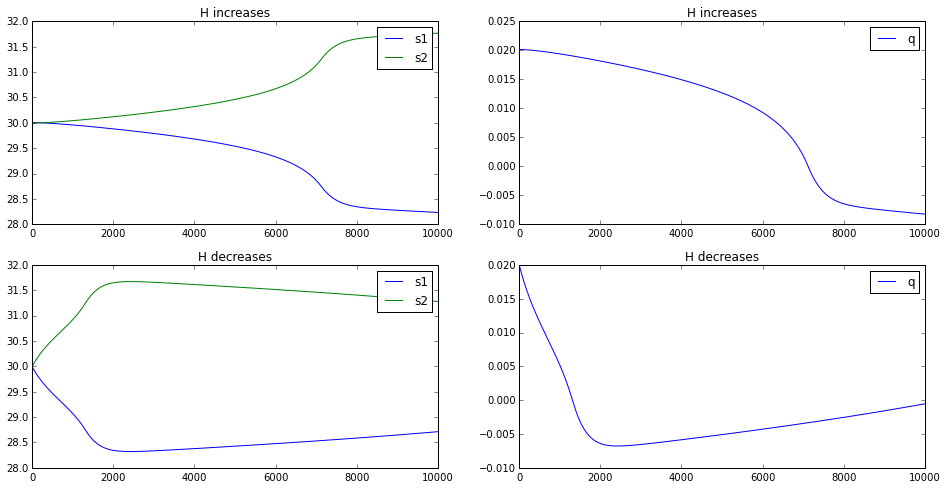

In [14]:
plt.figure(figsize=[16,8])
plt.subplot(2,2,1)
plt.plot(ms1.T,label='s1')
plt.plot(ms2.T,label='s2')
plt.legend()
plt.title('H increases')
plt.subplot(2,2,2)
plt.plot(mq.T,label='q')
plt.legend()
plt.title('H increases')
plt.subplot(2,2,3)
plt.plot(ns1.T,label='s1')
plt.plot(ns2.T,label='s2')
plt.legend()
plt.title('H decreases')
plt.subplot(2,2,4)
plt.plot(nq.T,label='q')
plt.legend()
plt.title('H decreases')

# assimilation 

In [15]:
def assimilate(x,m,H,obs_std,members=50):
    xb_bar=x.mean(axis=0)
    xb_prime=x-xb_bar
    yo=np.dot(H,m)+np.random.randn(H.shape[1])*obs_std**2
    Pb=np.sum(np.abs(xb_prime[:,:,np.newaxis])*np.abs(xb_prime\
                                            [:,np.newaxis,:]),axis=0)/(members-1)
    
    R=np.eye(H.shape[0])*obs_std**2
    K=np.dot(np.dot(Pb,H.T),np.linalg.inv(np.dot(np.dot(H,Pb),H.T)+R))

    xbar_a=xb_bar+np.dot(K,(yo-np.dot(H,xb_bar)))
    xprime_a=np.zeros_like(xb_prime)
    xa=np.zeros_like(xb_prime)

    yprime=np.random.randn(len(yo))*obs_std**2
        
    for i in range(members):
        xprime_a[i]=xb_prime[i]+np.dot(K,yprime-np.dot(H,xb_prime[i]))
        xa[i]=xbar_a+xprime_a[i]
    return xa

In [19]:
m=stommel_model(H=0,S1=30,S2=30)
ens=stommel_model(members=50)
ens.T1=m.T1[0]+np.random.randn(ens.members,m.n)
ens.T2=m.T2[0]+np.random.randn(ens.members,m.n)
ens.S1=m.S1[0]+np.random.randn(ens.members,m.n)
ens.S2=m.S2[0]+np.random.randn(ens.members,m.n)

In [20]:
run=10000
cycle=500
q=np.array([])
enq=np.array([])
S1=np.array([])
S2=np.array([])
enS1=np.array([])
enS2=np.array([])
H=np.eye(20)
os=0.5

for i in range(run):
    m.rk4step()
    ens.rk4step()
    m.H=H_range[-i]
    ens.H=H_range[-i]
    if np.mod(i,cycle)==0:
        ens.T1=assimilate(ens.T1,m.T1[0],H,obs_std=os)
        ens.T2=assimilate(ens.T2,m.T2[0],H,obs_std=os)
        ens.S1=assimilate(ens.S1,m.S1[0],H,obs_std=os)
        ens.S2=assimilate(ens.S2,m.S2[0],H,obs_std=os)
    q=np.append(q,m.q.mean())
    enq=np.append(enq,ens.q.mean())
    S1=np.append(S1,m.S1.mean())
    S2=np.append(S2,m.S2.mean())
    enS1=np.append(enS1,ens.S1.mean())
    enS2=np.append(enS2,ens.S2.mean())

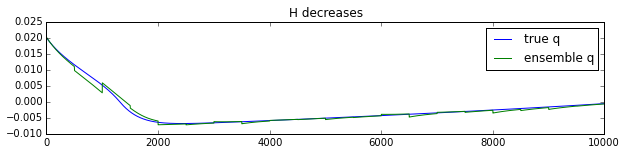

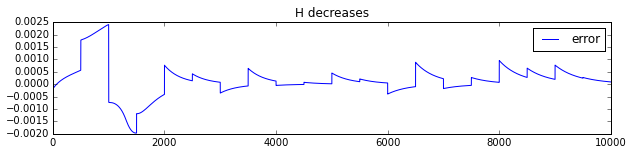

In [21]:
plt.figure(figsize=(10,2))
plt.plot(q,label='true q')
plt.plot(enq,label='ensemble q')
plt.title('H decreases')
plt.legend()
plt.figure(figsize=(10,2))
plt.plot(q-enq,label='error')
plt.title('H decreases')
plt.legend()

In [25]:
m=stommel_model(H=0,S1=30,S2=30)
ens=stommel_model(members=50)
ens.T1=m.T1[0]+np.random.randn(ens.members,m.n)
ens.T2=m.T2[0]+np.random.randn(ens.members,m.n)
ens.S1=m.S1[0]+np.random.randn(ens.members,m.n)
ens.S2=m.S2[0]+np.random.randn(ens.members,m.n)


In [26]:
run=10000
cycle=500
q=np.array([])
enq=np.array([])
S1=np.array([])
S2=np.array([])
enS1=np.array([])
enS2=np.array([])
H=np.eye(20)
os=0.5

for i in range(run):
    m.rk4step()
    ens.rk4step()
    m.H=H_range[i]
    ens.H=H_range[i]
    if np.mod(i,cycle)==0:
        ens.T1=assimilate(ens.T1,m.T1[0],H,obs_std=os)
        ens.T2=assimilate(ens.T2,m.T2[0],H,obs_std=os)
        ens.S1=assimilate(ens.S1,m.S1[0],H,obs_std=os)
        ens.S2=assimilate(ens.S2,m.S2[0],H,obs_std=os)
    q=np.append(q,m.q.mean())
    enq=np.append(enq,ens.q.mean())
    S1=np.append(S1,m.S1.mean())
    S2=np.append(S2,m.S2.mean())
    enS1=np.append(enS1,ens.S1.mean())
    enS2=np.append(enS2,ens.S2.mean())

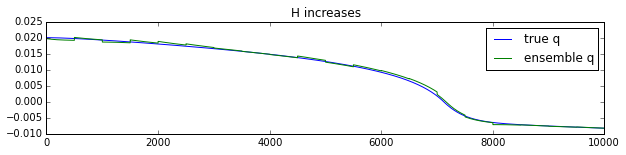

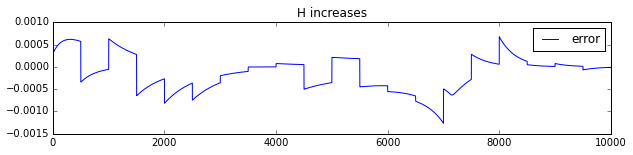

In [27]:
plt.figure(figsize=(10,2))
plt.plot(q,label='true q')
plt.plot(enq,label='ensemble q')
plt.title('H increases')
plt.legend()
plt.figure(figsize=(10,2))
plt.plot(q-enq,label='error')
plt.title('H increases')
plt.legend()